In [1]:
import sys,os
import glob
import torch,dill
import torchvision.utils as vutils
import matplotlib.pyplot as plt
#from iresnet import iResBlock
#from iEluNetwork import iConv2d
#from spectral_norm import SN
import numpy as np
import seaborn as sb
import torch.nn.functional as F
import pandas as pd
import flow_ssl

In [2]:
paths = glob.glob(os.path.expanduser('~/tb-experiments/iresnet_WTW/**/*.trainer'),recursive=True)
elu_paths = glob.glob(os.path.expanduser('~/tb-experiments/elu_flow_full_slrelu2/**/*.trainer'),recursive=True)
elu_paths = glob.glob(os.path.expanduser('~/tb-experiments/linear_coords_avgpool_fast/**/*.trainer'),recursive=True)
paths = elu_paths
print(paths)


['/home/marc/tb-experiments/linear_coords_avgpool_fast/CIFAR10/iLinear3d/0.0003/trial0/checkpoints/c5.trainer']


In [3]:
trainer = torch.load(paths[-1],pickle_module=dill)
trainer.model.eval();

In [ ]:
# def change_tol(module):
#     if isinstance(module,iResBlock):
#         module.inverse_tol=1e-10
#         print(module.iters_per_reverse)
#     if isinstance(module,SN):
#         print(module._s)
#     if isinstance(module,iConv2d):
#         print(module._reverse_iters)
#         try: print(module.iters_per_reverse)
#         except ZeroDivisionError: pass
# trainer.model.apply(change_tol);

In [ ]:
zs = []
with torch.no_grad():
    for mb in trainer.dataloaders['train']:
        z = trainer.model.get_all_z_squashed(mb[0]).reshape(mb[0].shape[0],-1).cpu().data.numpy()
        zs.append(z)
        if len(zs) > 100: break


In [ ]:
Zs = np.concatenate(zs)

In [ ]:
Zs.shape

In [ ]:
#sb.distplot(Zs[:,0])
for i in range(10):
    sb.distplot(Zs[:,i]+1*i,kde=False,label=i)
#plt.yscale('log')
#plt.xscale('log')
#plt.legend()

In [4]:
def get_nlls(dataloader):
    nlls = []
    with torch.no_grad():
        for mb in dataloader:
            nlls.append(trainer.model.nll(mb[0]).cpu().data.numpy())
    return np.concatenate(nlls)

In [5]:
from oil.datasetup.datasets import CIFAR10,CIFAR100,SVHN
from torch.utils.data import DataLoader
from oil.utils.utils import LoaderTo

In [12]:
C100,SVHN_ = [dataset(f'~/datasets/{dataset}/',flow=True) for dataset in (CIFAR100,SVHN)]
C100L,SVHNL =  [LoaderTo(DataLoader(data,batch_size=50,shuffle=False),torch.device('cuda')) for data in (C100,SVHN_)]

Files already downloaded and verified
Using downloaded and verified file: /home/marc/datasets/SVHN/train_32x32.mat


In [13]:
#train_nlls = get_nlls(trainer.dataloaders['train'])
#dev_nlls = get_nlls(trainer.dataloaders['dev'])
C100_nlls = get_nlls(C100L)
SVHN_nlls = get_nlls(SVHNL)

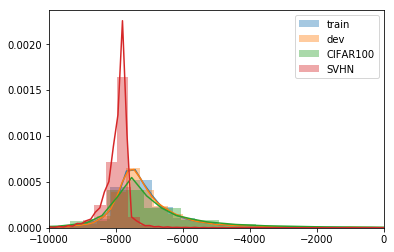

In [16]:
sb.distplot(train_nlls)
sb.distplot(dev_nlls)
sb.distplot(C100_nlls)
sb.distplot(SVHN_nlls)
plt.xlim(-10000,0)
plt.legend(["train","dev","CIFAR100","SVHN"])

In [ ]:
for mb in trainer.dataloaders['dev']:
    break
inp =x=mb[0]
with torch.no_grad():
    output = trainer.model.body(inp)
    inp_rec = trainer.model.inverse(output)

In [ ]:
for module in trainer.model.body._modules.values():
    print(module)

In [ ]:
trainer.model.logdet()

In [ ]:
((inp_rec[0] - inp[0]).norm()/(inp[0]).norm())

In [ ]:
%debug

In [ ]:
x = np.linspace(-10,5,100)
beta = .1
alpha = (1-beta)/(1+beta)
elu = lambda x: (x>=0)*x +  (x<0)*(np.exp(x)-1)
lelu = lambda x: (x+alpha*(np.sqrt(1+x**2)-1))/(1+alpha)
leakyrelu = lambda x: (x>=0)*x +  (x<0)*.1*x

In [ ]:
plt.plot(x,elu(x))
plt.plot(x,lelu(x))
plt.plot(x,leakyrelu(x))
plt.legend(["elu",r"smooth lrelu = $(x+\alpha*(\sqrt{1+x^2}-1))/(1+\alpha)$",r"Leaky Relu $\beta = .1$"])

In [ ]:
def slrelu_inverse(y,a):
    b = (1+a)*y + a
    x = (np.sqrt(a**2 + (a*b)**2-a**4) - b)/(a**2-1)
    return x

In [ ]:
plt.plot(x,slrelu_inverse(lelu(x),alpha))

In [ ]:
inp_rec.shape

In [ ]:
plt.imshow(inp_rec[0].cpu().data.numpy().transpose((1,2,0)))
plt.show()
plt.imshow(inp[0].cpu().data.numpy().transpose((1,2,0)))
plt.show()

In [ ]:
((inp_rec - inp).norm()/(inp[0]).norm())

In [ ]:
plt.hist(output.cpu().numpy().reshape(-1))

In [ ]:
with torch.no_grad():
    output = trainer.model[1].body(inp)

In [ ]:
trainer.model.eval()
with torch.no_grad():
    sampled_imgs = trainer.model.sample(32).cpu().data

In [ ]:
sampled_imgs

In [ ]:
grid = vutils.make_grid(sampled_imgs, normalize=True)
plt.imshow(grid.permute(1,2,0))

In [ ]:
grid.shape

In [ ]:
list(z_.shape for z_ in output)

In [ ]:
with torch.no_grad():
    inp_reconstructed = trainer.model[1].body.inverse(output);

In [ ]:
((inp_reconstructed[0] - inp[0]).norm()/(inp[0]).norm())

In [ ]:
plt.hist(inp_reconstructed[0].cpu().data.numpy().reshape(-1),alpha=.5)
plt.hist(inp[0].cpu().data.numpy().reshape(-1),alpha=.5)

In [ ]:
fig = plt.gcf()
fig.set_size_inches(18.5, 10.5)
#print(y.shape)
grid = vutils.make_grid(mb[0]).cpu().data.numpy().transpose(1,2,0)
plt.imshow(grid)
plt.show()
grid = vutils.make_grid(inp_reconstructed).cpu().data.numpy().transpose(1,2,0)
plt.imshow(grid)
fig = plt.gcf()
fig.set_size_inches(18.5, 10.5)

In [ ]:
for zi in z: print(zi.shape)

In [ ]:
import torch
from downsample import SqueezeLayer
from downsample import NNdownsample,iAvgPool2d

In [ ]:
S = SqueezeLayer(2)

In [ ]:
x = torch.Tensor([0,1,2,3,4,5,6,7]).reshape(1,2,2,2)

In [ ]:
S(x)

In [ ]:
x

In [ ]:
z = S(x-F.interpolate(F.interpolate(x,scale_factor=1/2),scale_factor=2))

In [ ]:
S2 = iAvgPool2d()#NNdownsample()

In [ ]:
x

In [ ]:
S2.inverse(S2(x))

In [ ]:
S2(x)